TODO:
1. IMPOSE BOUNDARY VALUE CONDITIONS! (very important to do, see observation below)
2. Compute errors on all dataset (generalize functions)
3. Verify verformance on testing
4. Try to improve the model changing weight_decay and number of neurons of fully connected

OBSERVATIONS:
1. The model learn well inside the interval! So impose the boundary value functions somewhere (think about it), as well as masking

In [4]:
import graph as gr
import numpy as np
import networkx as nx

import torch
torch.manual_seed(12121998)
import torch.nn.functional as F

from torch.nn import Linear, ReLU, Hardtanh, Sigmoid
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import basic_gnn as torch_models

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import time

c:\ProgramData\Anaconda3\envs\my-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating Dataset

In [5]:
# MACROS
COORDINATES_FEATURE_FLAG = False # If true also position is used as feature!
NORMALIZE_TARGET_FLAG    = True # normalize output!
norm_inter = [0, 1] # Interval where to normalize data

In [6]:
# FILENAMES AND FILEPATH

# mesh name
mesh_filename = "simple_laplacian_mesh"
## target filepaths (you can add other targets)
target_filepaths  = ["../mesh/simple_laplacian_u.txt"]
## feature filepaths 
feature_filepaths = ["../mesh/simple_laplacian_f.txt"]

# Testing
test_target_filepaths = ["../mesh/test_simple_laplacian_u.txt"]
test_feature_filepaths = ["../mesh/test_simple_laplacian_f.txt"]


In [7]:
folder = gr.import_mesh(mesh_filename)
loaded_graph = gr.build_graph(folder)
loaded_adj = gr.build_adjacency(loaded_graph, folder)

loaded_targets = [torch.tensor(0)] * len(target_filepaths)
for i, data in enumerate(target_filepaths):
    loaded_targets[i] = torch.tensor(gr.import_features(data)).double()

loaded_features = [torch.tensor(0)] * len(feature_filepaths)
for i, data in enumerate(feature_filepaths):
    loaded_features[i] = torch.tensor(gr.import_features(data)).double()


if NORMALIZE_TARGET_FLAG:
    u_max = [None] * len(loaded_targets)
    u_min = [None] * len(loaded_targets)
    for i, data in enumerate(loaded_targets):
        u_max[i] = data.max()
        u_min[i] = data.min()
        loaded_targets[i] = (norm_inter[1] - norm_inter[0]) * (data - u_min[i]) / (u_max[i] - u_min[i]) + norm_inter[0]  

        
# Testing
test_loaded_targets = [torch.tensor(0)] * len(test_target_filepaths)
for i, data in enumerate(test_target_filepaths):
    test_loaded_targets[i] = torch.tensor(gr.import_features(data)).double()
    
test_loaded_features = [torch.tensor(0)] * len(test_feature_filepaths)
for i, data in enumerate(test_feature_filepaths):
    test_loaded_features[i] = torch.tensor(gr.import_features(data)).double()


In [8]:
## TORCH DATASET (see torch_geometric.data)

# will be used to create the complete dataset
tot_samples = loaded_targets[0].shape[1]
data_list = [torch.tensor(0)] * tot_samples

# INITIALIZING COMMON PROPERTIES TO ALL GRAPHS

# Graph connectivity
edge_index = torch.tensor([ [i,j] for i in range(loaded_adj.shape[0]) for j in range(loaded_adj.shape[1]) if loaded_adj[i,j]>0 ])

# Node position matrix
pos = torch.hstack((
                    torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'x').values())), 1 ),
                    torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'y').values())), 1 ) 
                  )).double()


In [9]:
# INITIALIZING THE DIFFERENT GRAPHS

for t in range(tot_samples):
    
    ## Node feature matrix
    
    x = loaded_features[0][:, t][:, None]
    # other features (forcing f values)
    [x := torch.hstack((x, loaded_features[j][:, t][:, None])) for j in range(1,len(loaded_features))]
    if COORDINATES_FEATURE_FLAG: [x := torch.hstack((x, pos))]
    
    ## Node-level ground-truth labels (heat)
    
    # first feature (pression or velocity or ...)
    y = loaded_targets[0][:, t][:, None]
    # other features (pression, velocities, ...)
    [y := torch.hstack((y, loaded_targets[j][:, t][:, None])) for j in range(1,len(loaded_targets))]

    data_list[t] = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, pos=pos)

In [10]:
# BORDER MASK
label = torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'n').values())), 1).double()
mask  = label == 0.

In [11]:
dataloader = DataLoader(data_list, batch_size = 1, shuffle = True)

In [12]:
# Creating Test dataset
test_total_samples = test_loaded_targets[0].shape[1]
test_data_list = [torch.tensor(0)] * test_total_samples

for t in range(test_total_samples):
    
    ## Node feature matrix
    
    x = test_loaded_features[0][:, t][:, None]
    # other features (forcing f values)
    [x := torch.hstack((x, test_loaded_features[j][:, t][:, None])) for j in range(1,len(test_loaded_features))]
    if COORDINATES_FEATURE_FLAG: [x := torch.hstack((x, pos))]
    
    ## Node-level ground-truth labels (heat)
    
    # first feature (pression or velocity or ...)
    y = test_loaded_targets[0][:, t][:, None]
    # other features (pression, velocities, ...)
    [y := torch.hstack((y, test_loaded_targets[j][:, t][:, None])) for j in range(1,len(test_loaded_targets))]

    test_data_list[t] = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, pos=pos)


In [13]:
test_dataloader = DataLoader(test_data_list, batch_size = 1, shuffle = False)

# Model

In [14]:
conv_input_size = dataloader.dataset[0].num_node_features
input_size      = dataloader.dataset[0].num_nodes
output_size     = dataloader.dataset[0].num_nodes
feature_size    = dataloader.dataset[0].x.size()[-1]

In [15]:
#from torch_geometric.nn import Sequential
class GAT(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.heads1 = 4
        self.conv1 = GATConv(conv_input_size, conv_input_size, heads = self.heads1, concat = False)
        
        self.heads2 = 4
        self.conv2 = GATConv(conv_input_size, conv_input_size, heads = self.heads2, concat = False)
                
        self.fc = torch.nn.Sequential(
            Linear(input_size, 32),
            ReLU(),
            Linear(32, 32),
            ReLU(),
            Linear(32, output_size),
            Sigmoid()
        )
                

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(torch.flatten(x))
        
        return x

GAT_model = GAT().double()
print(GAT_model)

GAT(
  (conv1): GATConv(1, 1, heads=4)
  (conv2): GATConv(1, 1, heads=4)
  (fc): Sequential(
    (0): Linear(in_features=1089, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1089, bias=True)
    (5): Sigmoid()
  )
)


In [16]:
learning_rate = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GAT_model.parameters(), lr=learning_rate)#, weight_decay=1e-6)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    tot_loss = 0
    loss = 0
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(data.x, data.edge_index)
        #loss = loss_fn(pred[mask], data.y[mask])
        loss = loss_fn(pred, torch.flatten(data.y)) 

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
    print("loss: {:1.3e}".format(tot_loss / len(dataloader)))

In [18]:
epochs = 30
start = time.time()

for t in range(epochs):
    print("-------------------------------")
    print(f"Epoch {t+1}")
    train_loop(dataloader, GAT_model, loss_fn, optimizer)
print("-------------------------------")
print("Done!")

end = time.time()
elapsed_time = end - start
minutes = elapsed_time //60
seconds = elapsed_time - 60*minutes
print(f"Elapsed time: {minutes:2.0f} min, {seconds:2.0f} sec")

-------------------------------
Epoch 1
loss: 1.162e-02
-------------------------------
Epoch 2
loss: 5.498e-03
-------------------------------
Epoch 3
loss: 3.547e-03
-------------------------------
Epoch 4
loss: 2.334e-03
-------------------------------
Epoch 5
loss: 7.128e-04
-------------------------------
Epoch 6
loss: 8.756e-05
-------------------------------
Epoch 7
loss: 5.058e-05
-------------------------------
Epoch 8
loss: 5.203e-05
-------------------------------
Epoch 9
loss: 4.367e-05
-------------------------------
Epoch 10
loss: 4.653e-05
-------------------------------
Epoch 11
loss: 4.452e-05
-------------------------------
Epoch 12
loss: 4.038e-05
-------------------------------
Epoch 13
loss: 5.209e-05
-------------------------------
Epoch 14
loss: 4.728e-05
-------------------------------
Epoch 15
loss: 5.685e-05
-------------------------------
Epoch 16
loss: 4.383e-05
-------------------------------
Epoch 17
loss: 2.999e-05
-------------------------------
Epoch 18

In [19]:
def denormalize(tensor):
    tensor = (tensor - norm_inter[0]) / (norm_inter[1] - norm_inter[0])
    tensor = tensor * (u_max[0] - u_min[0]) + u_min[0]
    return torch.flatten(tensor.clone().detach())

true = denormalize(data_list[-1].y) 
print("True values: ")
print(true)

pred = denormalize(GAT_model(dataloader.dataset[-1]['x'], dataloader.dataset[0]['edge_index']))
print("Prediction: ")
print(pred)

True values: 
tensor([ 1.0000,  1.0002,  1.0012,  ..., 10.1199, 10.5457, 11.0000],
       dtype=torch.float64)
Prediction: 
tensor([ 1.0000,  1.0000,  1.0000,  ...,  9.7983, 10.1309, 10.4055],
       dtype=torch.float64)


In [20]:
L1_loss = torch.nn.L1Loss()
L2_loss = torch.nn.MSELoss()

err = {
    "Mean Absolute Error": L1_loss(true, pred).item(),
    "Mean Squared Error":  L2_loss(true, pred).item(),
    "Minimum Error": abs(true - pred).min().item(),
    "Maximum Error": abs(true - pred).max().item(),
    "Average Error": abs(true - pred).mean().item() 
    }

# print each data item.
for key, value in err.items():
    print ("{:<20} {:1.3e}".format(key, value))

Mean Absolute Error  3.579e-02
Mean Squared Error   3.272e-03
Minimum Error        6.305e-07
Maximum Error        5.945e-01
Average Error        3.579e-02


In [21]:
def plot(ax, dataloader, output, title):
    
    # plots a finite element mesh
    def plot_fem_mesh(nodes_x, nodes_y, elements):
        for element in elements:
            x = [nodes_x[element[i]] for i in range(len(element))]
            y = [nodes_y[element[i]] for i in range(len(element))]
            ax.fill(x, y, edgecolor='black', fill=False, linewidth='0.5', alpha=0.3)

    # FEM data
    nodes_x = dataloader.dataset[0]['pos'][:,0]
    nodes_y = dataloader.dataset[0]['pos'][:,1]
    nodal_values = output # loaded_features[0][:, 0]
    elements = np.load(folder+"/triangles.npy")
    triangulation = tri.Triangulation(nodes_x, nodes_y, elements)

    # plot the contours
    tcf = ax.tricontourf(triangulation,  nodal_values)
    plt.colorbar(tcf, ax=ax)

    # plot the finite element mesh
    plot_fem_mesh(nodes_x, nodes_y, elements)
    #ax.axis('equal')
    ax.set_title(title, fontsize=20)


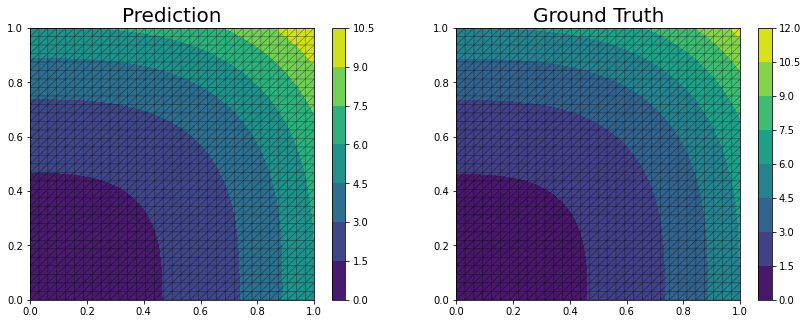

In [22]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
plot(axs[0], dataloader, pred, "Prediction")
plot(axs[1], dataloader, true, "Ground Truth")
plt.show()

## Testing

In [23]:
true = torch.flatten(test_data_list[-2].y)
print("True values: ")
print(true)

pred = denormalize(GAT_model(test_dataloader.dataset[-2]['x'], test_dataloader.dataset[-2]['edge_index']))
print("Prediction: ")
print(pred)

True values: 
tensor([ 1.0000,  1.0002,  1.0012,  ...,  9.9907, 10.4105, 10.8584],
       dtype=torch.float64)
Prediction: 
tensor([ 1.0000,  1.0000,  1.0000,  ...,  9.7213, 10.0628, 10.3513],
       dtype=torch.float64)


In [24]:
L1_loss = torch.nn.L1Loss()
L2_loss = torch.nn.MSELoss()

err = {
    "Mean Absolute Error": L1_loss(true, pred).item(),
    "Mean Squared Error":  L2_loss(true, pred).item(),
    "Minimum Error": abs(true - pred).min().item(),
    "Maximum Error": abs(true - pred).max().item(),
    "Average Error": abs(true - pred).mean().item() 
    }

    
# print each data item.
for key, value in err.items():
    print ("{:<20} {:1.3e}".format(key, value))


Mean Absolute Error  3.560e-02
Mean Squared Error   2.771e-03
Minimum Error        7.917e-07
Maximum Error        5.071e-01
Average Error        3.560e-02


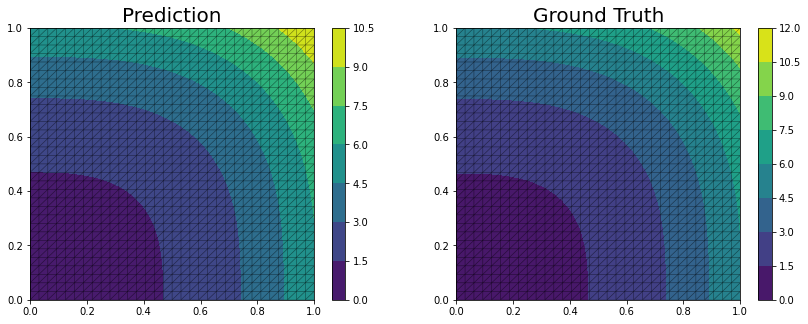

In [25]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
plot(axs[0], test_dataloader, pred, "Prediction")
plot(axs[1], test_dataloader, true, "Ground Truth")
plt.show()

In [26]:
def compute_error(dataloader, data_list):
    L1_loss = torch.nn.L1Loss()
    L2_loss = torch.nn.MSELoss() 
    MAE = []
    MSE = []

    for i in range(len(dataloader)):
        true = torch.flatten(test_data_list[i].y) 
        pred = denormalize(GAT_model(dataloader.dataset[i]['x'], dataloader.dataset[i]['edge_index']))
        MAE.append(L1_loss(true, pred).item())
        MSE.append(L2_loss(true, pred).item())

    MAE = np.array(MAE)
    MSE = np.array(MSE)
    return {"Average MAE": MAE.mean(),
            "Average MSE": MSE.mean(),
            "Minimum MAE": MAE.min(),
            "Maximum MAE": MAE.max(),
            "Minimum MSE": MSE.min(),
            "Maximum MSE": MSE.max(),
            "MAE Variance": MAE.std(),
            "MSE Variance": MSE.std()}

    

In [27]:
test_error = compute_error(test_dataloader, test_data_list)

print(test_error)

{'Average MAE': 0.033304472066104235, 'Average MSE': 0.0018044937662406429, 'Minimum MAE': 0.004124914141056251, 'Maximum MAE': 0.04963004477194043, 'Minimum MSE': 9.901588231617233e-05, 'Maximum MSE': 0.003395584332850625, 'MAE Variance': 0.00011098736210419889, 'MSE Variance': 8.99854298553136e-07}
